<a href="https://colab.research.google.com/github/Andreas-Lukito/Air_Quality_Prediction/blob/main/Air_quality_prediction_colab_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Quality Prediction

In this project, a multivariate time series forecasting model is developed to predict air temperature (AT) one hour ahead based on past sensor data. Two LSTM-based models are built:

    A baseline LSTM model with a hidden size of 10

    A proposed LSTM model optimized using Optuna for hyperparameter tuning.

Both models use a window size of 5, meaning they take the previous 5 hours of multivariate data as input to predict the next hour's AT. Model performance is evaluated using Mean Absolute Error (MAE), Mean Squared Error (MSE), and the R² Score.

## Import Libraries

### Install Libraries

In [1]:
!pip install optuna
!pip install pynvml
!pip install torch
!pip install matplotlib
!pip install pandas
!pip install sklearn
!pip install tqdm
!pip install plotly
!pip install -U kaleido

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
# Common libraries
import os
import json
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
from math import sqrt
import time
from IPython.display import clear_output

# Plotting libraries
import matplotlib.pyplot as plt
import plotly
import plotly.io as pio
import random #this will be used to randomly generate color

# Preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep learning libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

# Hyper Parameter Tuning
import optuna
from optuna.trial import TrialState

## GPU Check

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Pytorch is using the GPU")

    import pynvml
    pynvml.nvmlInit()

    num_gpus = pynvml.nvmlDeviceGetCount()

    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    pynvml.nvmlShutdown()
else:
    print("Pytorch is not using the GPU")



Pytorch is using the GPU
GPU Name: Tesla T4


## Import the Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/project_air_quality/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset = pd.read_csv(os.path.join(project_path, "dataset/AP004.csv"))

## EDA

The dataset contains these columns:

| Column Name         | Description                              | Unit  |
| ------------------- | ---------------------------------------- | ----- |
| From Date           | Starting date of data collection         | -     |
| To Date             | Ending date of data collection           | -     |
| PM2.5 (ug/m³)       | Particulate Matter 2.5                   | µg/m³ |
| PM10 (ug/m³)        | Particulate Matter 10                    | µg/m³ |
| CO (mg/m³)          | Carbon Monoxide                          | mg/m³ |
| NO (ug/m³)          | Nitric Oxide                             | µg/m³ |
| NO₂ (ug/m³)         | Nitrogen Dioxide                         | µg/m³ |
| NOₓ (ppb)           | Nitrogen Oxides                          | ppb   |
| NH₃ (ug/m³)         | Ammonia                                  | µg/m³ |
| SO₂ (ug/m³)         | Sulfur Dioxide                           | µg/m³ |
| Temp (°C)           | Temperature                              | °C    |
| AT (°C)             | Air Temperature                          | °C    |
| BP (mmHg)           | Barometric Pressure                      | mmHg  |
| Benzene (ug/m³)     | Concentration of Benzene in the air      | µg/m³ |
| Toluene (ug/m³)     | Concentration of Toluene in the air      | µg/m³ |
| VWS (m/s)           | Vertical Wind Speed                      | m/s   |
| WS (m/s)            | Wind Speed                               | m/s   |
| WD (degree)         | Wind Direction                           | °     |
| Xylene (ug/m³)      | Concentration of Xylene in the air       | µg/m³ |
| MP-Xylene (ug/m³)   | Concentration of Meta-Para Xylene        | µg/m³ |
| Eth-Benzene (ug/m³) | Concentration of Ethylbenzene in the air | µg/m³ |
| Ozone (ug/m³)       | Ozone Concentration                      | µg/m³ |
| SR (W/m²)           | Solar Radiation                          | W/m²  |
| RH (%)              | Relative Humidity                        | %     |
| RF (mm)             | Rainfall                                 | mm    |


In [6]:
dataset.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,...,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,...,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,...,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,...,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,...,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   To Date              48802 non-null  object 
 2   PM2.5 (ug/m3)        46344 non-null  float64
 3   PM10 (ug/m3)         46917 non-null  float64
 4   NO (ug/m3)           47244 non-null  float64
 5   NO2 (ug/m3)          47224 non-null  float64
 6   NOx (ppb)            46628 non-null  float64
 7   NH3 (ug/m3)          47140 non-null  float64
 8   SO2 (ug/m3)          46649 non-null  float64
 9   CO (mg/m3)           46387 non-null  float64
 10  Ozone (ug/m3)        47156 non-null  float64
 11  Benzene (ug/m3)      46914 non-null  float64
 12  Toluene (ug/m3)      46908 non-null  float64
 13  Eth-Benzene (ug/m3)  23988 non-null  float64
 14  MP-Xylene (ug/m3)    39256 non-null  float64
 15  Temp (degree C)      21599 non-null 

In [8]:
is_na = pd.DataFrame(dataset.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(dataset) * 100)
is_na

,Number_Missing,Missing_Percentage
From Date,0,0.000000
To Date,0,0.000000
PM2.5 (ug/m3),2458,5.036679
PM10 (ug/m3),1885,3.862547
NO (ug/m3),1558,3.192492
NO2 (ug/m3),1578,3.233474
NOx (ppb),2174,4.454735
NH3 (ug/m3),1662,3.405598
SO2 (ug/m3),2153,4.411704
CO (mg/m3),2415,4.948568


Since the `Eth-Benzene (ug/m3)` and `Temp (degree C)` column has almost 50% of the data missing, it is best to drop the column since there is no use to forward fill the data.

In [9]:
dataset.duplicated().sum()

np.int64(0)

since there are no duplicated data we  will continue in cleaning the data

In [10]:
# The columns "Eth-Benzene (ug/m3)" and "Temp (degree C)" will be dropped
# because they contain around 50% missing values, making them unreliable for modeling.
# Additionally, the "To Date" and "From Date" column will be removed since it wont be a

dataset = dataset.drop(columns=["Eth-Benzene (ug/m3)", "Temp (degree C)", "To Date", "From Date"])


### Plotting the Distribution

In [11]:
numeric_data = dataset.select_dtypes(include=[np.number])

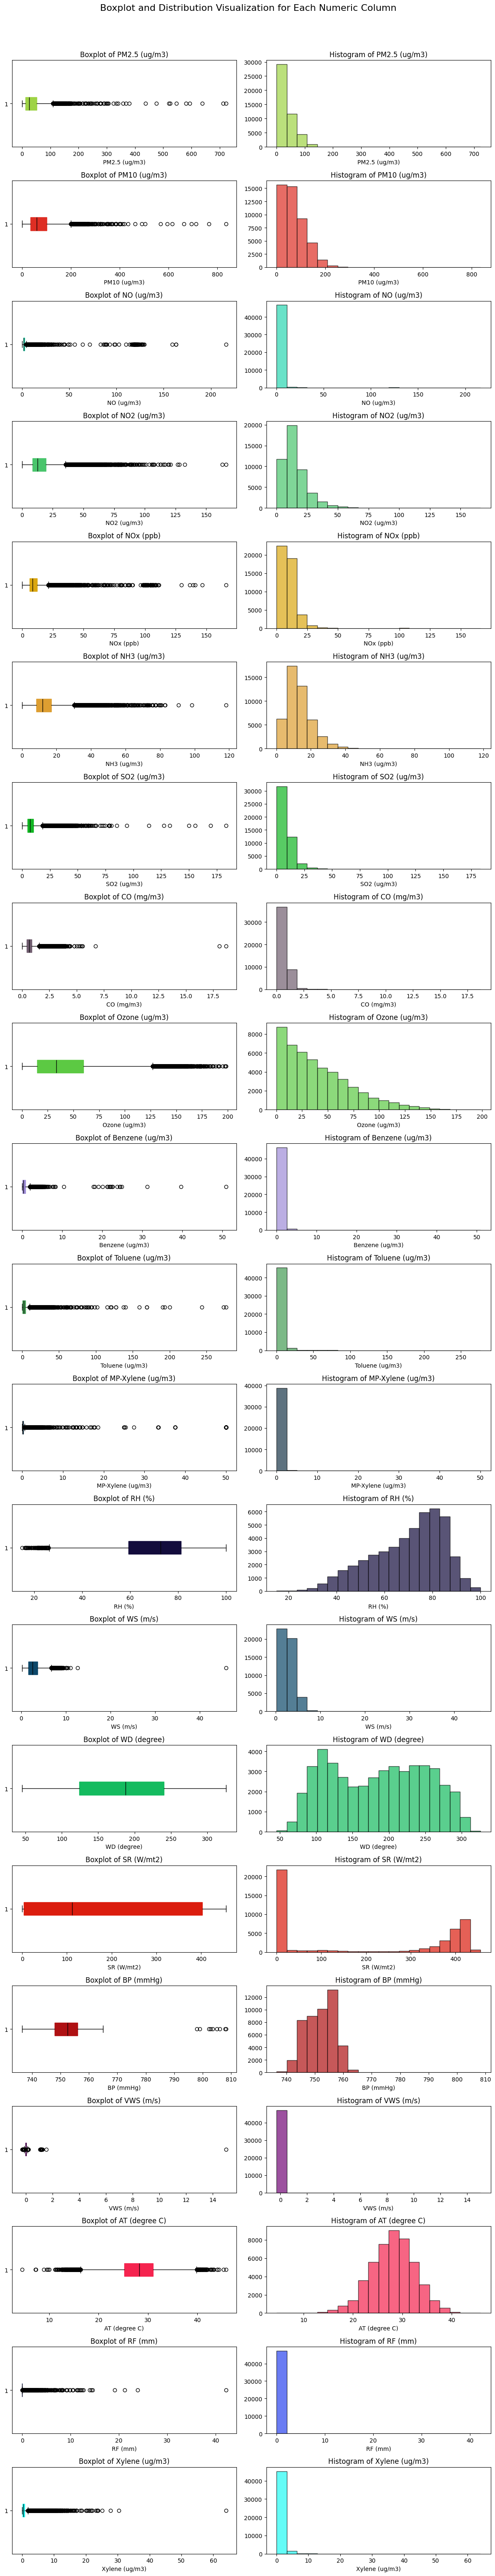

In [12]:
#titles for plots/figures
fig_titles = []

for colName in numeric_data.columns:
    fig_titles.append(f"Boxplot Of {colName}")
    fig_titles.append(f"Histogram Of {colName}")

#setting the colors for each column
def fill_color_generator():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

fill_color_dict = {}
for colName in numeric_data.columns:
    fill_color_dict[colName] = fill_color_generator()

# make subplot for each column name
num_rows = len(numeric_data.columns)
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

# Flatten axes for easier indexing when there's more than 1 row
axes = axes if num_rows > 1 else [axes]

for i, column in enumerate(numeric_data.columns):
    color = fill_color_dict[column]

    # Boxplot
    axes[i][0].boxplot(numeric_data[column].dropna(), vert=False, patch_artist=True,
                       boxprops=dict(facecolor=color, color=color),
                       medianprops=dict(color="black"))
    axes[i][0].set_title(f"Boxplot of {column}")
    axes[i][0].set_xlabel(column)

    # Histogram
    axes[i][1].hist(numeric_data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
    axes[i][1].set_title(f"Histogram of {column}")
    axes[i][1].set_xlabel(column)

# Overall layout
fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
plt.show()



since the data is very skewed, we might me using robust scaler.

## Preprocessing

### Split the Data to Train, Test, Validation

In [13]:
data_length = len(dataset)

train_size = int(data_length * 0.8) #80% train
val_size = int(data_length * 0.1) #10% validation
test_size = data_length - train_size - val_size  # the remaining data

train = dataset[0:train_size]
validation = dataset[train_size:train_size + val_size]
test = dataset[train_size + val_size:]

len(train)/data_length, len(validation)/data_length, len(test)/data_length

(0.7999877054219089, 0.09999590180730297, 0.10001639277078808)

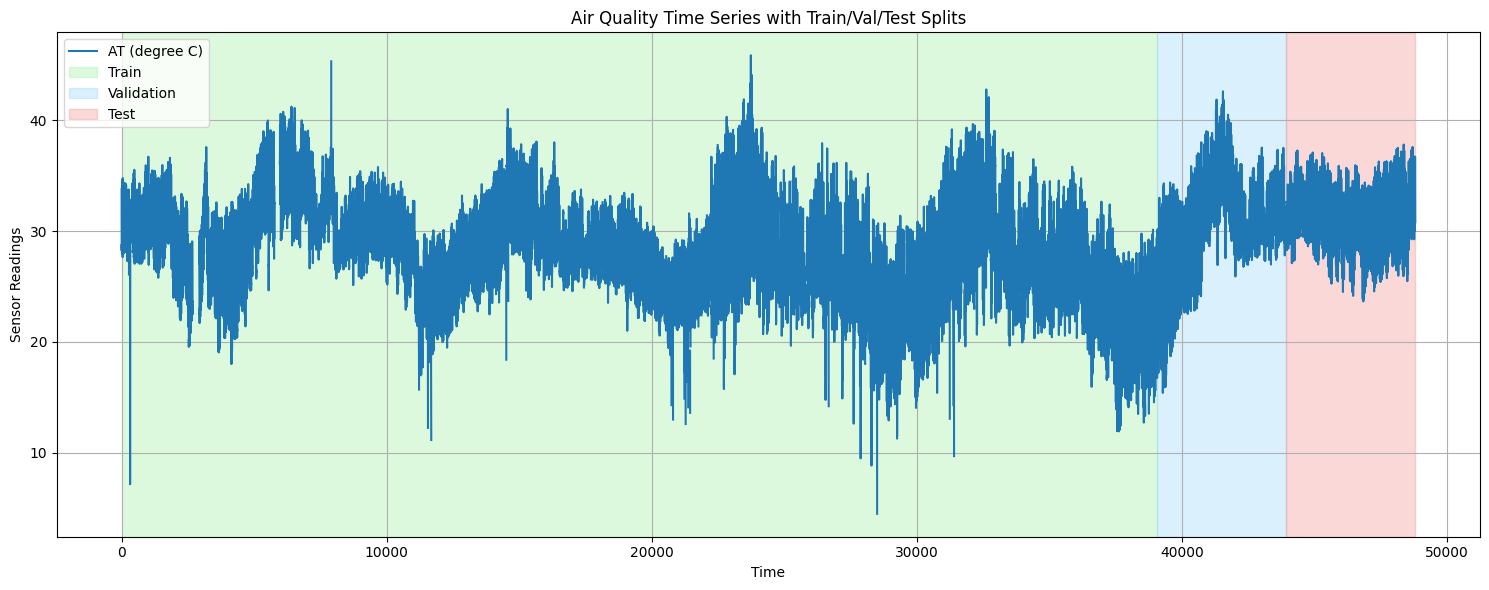

In [14]:
# Select the target features to plot
columns_to_plot = ['AT (degree C)']

# Split indexes
data_length = len(dataset)
train_end = int(data_length * 0.8)
val_end = int(data_length * 0.9)

# Plot
plt.figure(figsize=(15, 6))

# Plot each feature
for col in columns_to_plot:
    plt.plot(dataset.index, dataset[col], label=col, linewidth=1.5)

# Highlight train, val, test regions
plt.axvspan(dataset.index[0], dataset.index[train_end], color='lightgreen', alpha=0.3, label='Train') #avx span to draw shaded backgrounds
plt.axvspan(dataset.index[train_end], dataset.index[val_end], color='lightskyblue', alpha=0.3, label='Validation')
plt.axvspan(dataset.index[val_end], dataset.index[-1], color='lightcoral', alpha=0.3, label='Test')

plt.xlabel("Time")
plt.ylabel("Sensor Readings")
plt.title("Air Quality Time Series with Train/Val/Test Splits")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Cleaning Fixing the Missing Values

In [15]:
def clean_na(dataset: pd.DataFrame) -> pd.DataFrame:
    # Copy original to avoid manipulating the data directly
    cleaned = dataset.copy()

    # Select only numeric columns
    numeric_cols = cleaned.select_dtypes(include=[np.number]).columns

    # Fill only numeric columns
    ffill = cleaned[numeric_cols].ffill()
    bfill = cleaned[numeric_cols].bfill()
    averaged = (ffill + bfill) / 2

    # Assign back only the filled numeric columns
    cleaned[numeric_cols] = averaged

    return cleaned


In [16]:
# Now apply the function to the train, validation, test
train_clean = clean_na(train)
val_clean = clean_na(validation)
test_clean = clean_na(test)

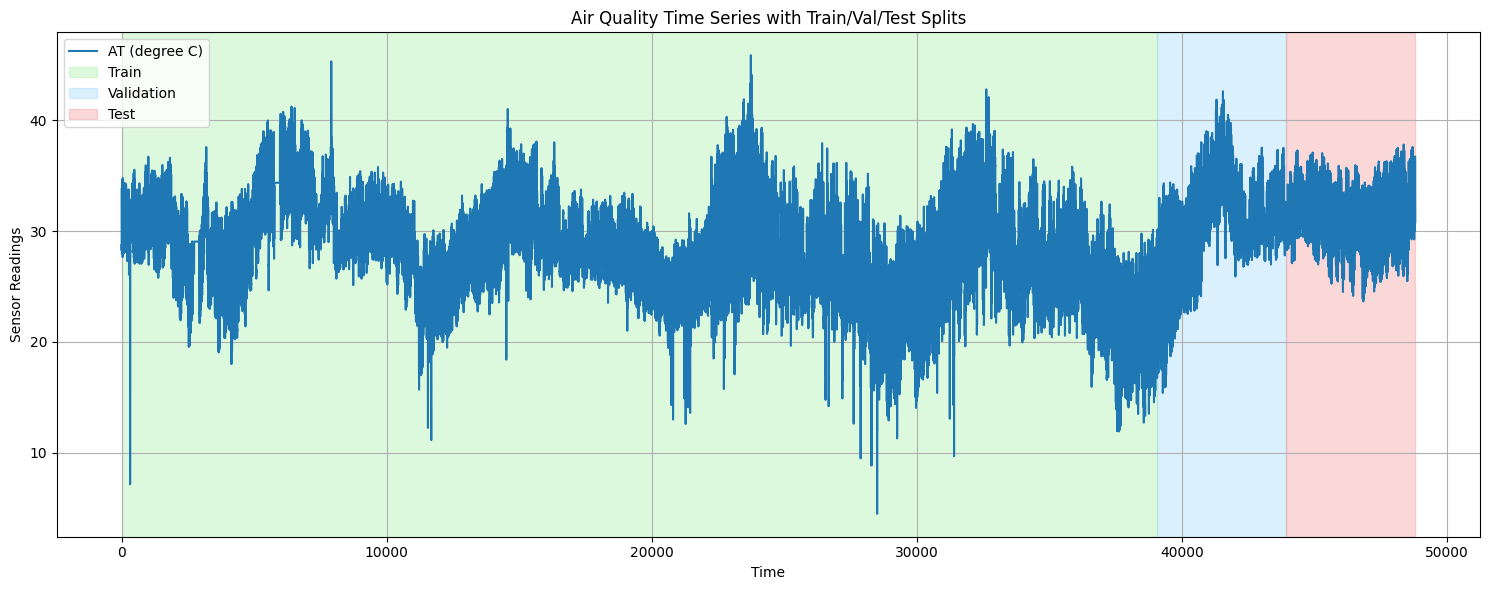

In [17]:
# Select the target features to plot
columns_to_plot = ['AT (degree C)']

# concatenate data for plotting
plot_df = pd.concat([train_clean, val_clean, test_clean])

# Split indexes
data_length = len(plot_df)
train_end = int(data_length * 0.8)
val_end = int(data_length * 0.9)

# Plot
plt.figure(figsize=(15, 6))

# Plot each feature
for col in columns_to_plot:
    plt.plot(plot_df.index, plot_df[col], label=col, linewidth=1.5)

# Highlight train, val, test regions
plt.axvspan(plot_df.index[0], plot_df.index[train_end], color='lightgreen', alpha=0.3, label='Train') #avx span to draw shaded backgrounds
plt.axvspan(plot_df.index[train_end], plot_df.index[val_end], color='lightskyblue', alpha=0.3, label='Validation')
plt.axvspan(plot_df.index[val_end], plot_df.index[-1], color='lightcoral', alpha=0.3, label='Test')

plt.xlabel("Time")
plt.ylabel("Sensor Readings")
plt.title("Air Quality Time Series with Train/Val/Test Splits")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Scaling the Data

In [18]:
#get the numeric columns
numeric_cols = train_clean.select_dtypes(include=[np.number]).columns

robust_scaler_dict = {}
min_max_scaler_dict = {}

train_scaled = train_clean.copy()
val_scaled = val_clean.copy()
test_scaled = test_clean.copy()

for col in numeric_cols:
    # Reshape for sklearn
    train_col = train_clean[[col]].values
    val_col = val_clean[[col]].values
    test_col = test_clean[[col]].values

    # Robust scaling (to reduce effect of outliers)
    robust_scaler = RobustScaler()
    train_robust = robust_scaler.fit_transform(train_col)
    val_robust = robust_scaler.transform(val_col)
    test_robust = robust_scaler.transform(test_col)
    robust_scaler_dict[col] = robust_scaler

    # Min-Max scaling (to ensure the output is from 0 to 1 so its easier for the model)
    minmax_scaler = MinMaxScaler()
    train_scaled[col] = minmax_scaler.fit_transform(train_robust)
    val_scaled[col] = minmax_scaler.transform(val_robust)
    test_scaled[col] = minmax_scaler.transform(test_robust)
    min_max_scaler_dict[col] = minmax_scaler


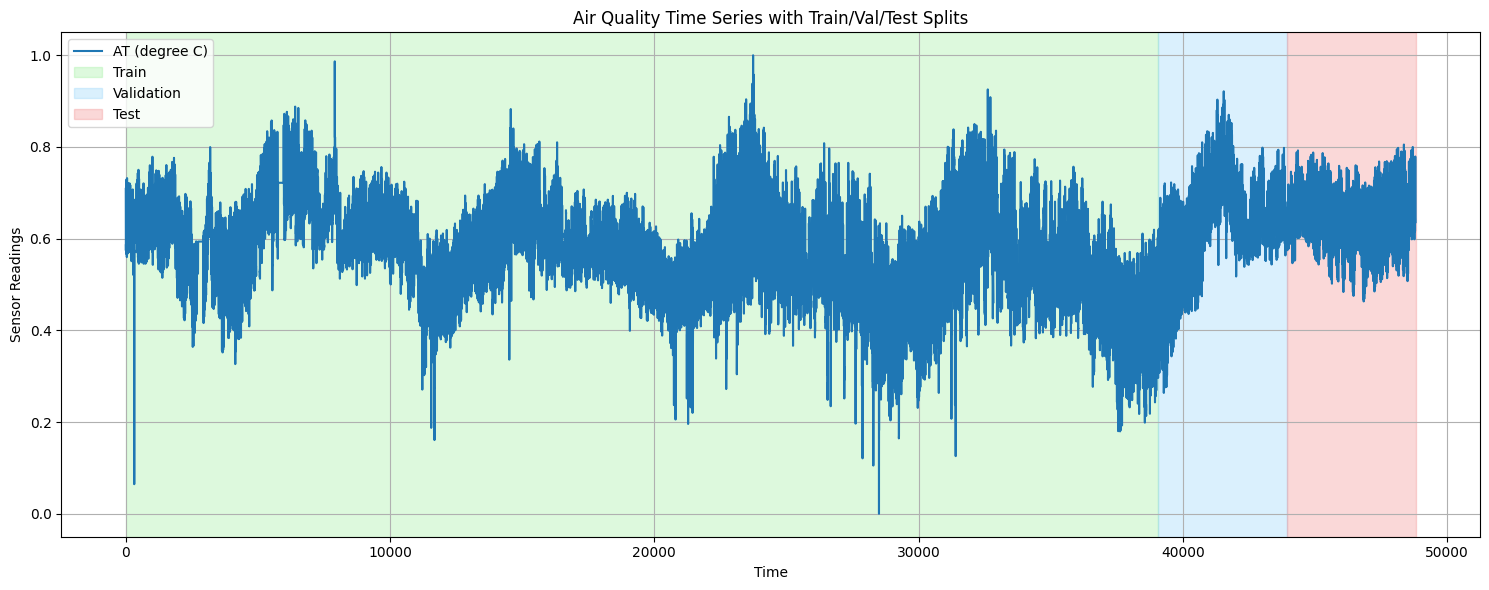

In [19]:
# Select the target features to plot
columns_to_plot = ['AT (degree C)']

# concatenate data for plotting
plot_df = pd.concat([train_scaled, val_scaled, test_scaled])

# Split indexes
data_length = len(plot_df)
train_end = int(data_length * 0.8)
val_end = int(data_length * 0.9)

# Plot
plt.figure(figsize=(15, 6))

# Plot each feature
for col in columns_to_plot:
    plt.plot(plot_df.index, plot_df[col], label=col, linewidth=1.5)

# Highlight train, val, test regions
plt.axvspan(plot_df.index[0], plot_df.index[train_end], color='lightgreen', alpha=0.3, label='Train') #avx span to draw shaded backgrounds
plt.axvspan(plot_df.index[train_end], plot_df.index[val_end], color='lightskyblue', alpha=0.3, label='Validation')
plt.axvspan(plot_df.index[val_end], plot_df.index[-1], color='lightcoral', alpha=0.3, label='Test')

plt.xlabel("Time")
plt.ylabel("Sensor Readings")
plt.title("Air Quality Time Series with Train/Val/Test Splits")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Reorder the Columns

Reordering the colums so that `AT (degree C)` is at the first column

In [20]:
column_order = ['AT (degree C)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)',
       'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
       'MP-Xylene (ug/m3)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)',
       'BP (mmHg)', 'VWS (m/s)', 'RF (mm)', 'Xylene (ug/m3)']

train_scaled = train_scaled.loc[:, column_order]
val_scaled = val_scaled.loc[:, column_order]
test_scaled = test_scaled.loc[:, column_order]

In [21]:
train_scaled.shape

(39041, 21)

### Prepare Data Frame for LSTM

In [22]:
# This is a function to shift the data so that lstm can recognize it

def dataframe_prep(data: pd.DataFrame, window_size: int):
    df = copy.deepcopy(data)

    shifted_dfs = [df]  # original data

    for col in df.columns:
        for i in range(1, window_size + 1):
            shifted_col = df[col].shift(i).rename(f"{col}_(t-{i})") # Rename columns while shifting
            shifted_dfs.append(shifted_col)

    # Concatenate all at once (avoids fragmentation)
    result = pd.concat(shifted_dfs, axis=1)

    # Drop rows with NaNs introduced by shifting
    result.dropna(inplace=True)

    return result

In [23]:
# apply to train test and validation
window_size = 5  # using past 5 time steps

train_seq = dataframe_prep(train_scaled, window_size)
val_seq   = dataframe_prep(val_scaled, window_size)
test_seq  = dataframe_prep(test_scaled, window_size)

In [24]:
train_seq.shape, val_seq.shape, test_seq.shape

((39036, 126), (4875, 126), (4876, 126))

In [25]:
train_seq.head(1)

,AT (degree C),PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,RF (mm)_(t-1),RF (mm)_(t-2),RF (mm)_(t-3),RF (mm)_(t-4),RF (mm)_(t-5),Xylene (ug/m3)_(t-1),Xylene (ug/m3)_(t-2),Xylene (ug/m3)_(t-3),Xylene (ug/m3)_(t-4),Xylene (ug/m3)_(t-5)
5,0.577993,0.009685,0.019755,0.004719,0.180861,0.101807,0.047821,0.023581,0.036918,0.114682,...,0.0,0.0,0.038912,0.0,0.0,0.033896,0.028897,0.008279,0.007498,0.00781


In [26]:
# Convert to NumPy arrays because PyTorch tensors are typically created from NumPy, not directly from DataFrames
train_seq_np = train_seq.to_numpy()
val_seq_np = val_seq.to_numpy()
test_seq_np = test_seq.to_numpy()

## Model Making

### Data Loader

In [27]:
train_scaled.shape, train_seq.shape

((39041, 21), (39036, 126))

#### Split the Data to X and Y

In [28]:
# Take x Values
x_train = train_seq_np[:, 1:]
x_val = val_seq_np[:, 1:]
x_test = test_seq_np[:, 1:]

# Take y Values
y_train = train_seq_np[:, 0]
y_val = val_seq_np[:, 0]
y_test = test_seq_np[:, 0]

#### Flip the data
so that the order is from oldest to newest (so the lstm processes the data from old to latest)

In [29]:
x_train = copy.deepcopy(np.flip(x_train, axis=1))
x_val = copy.deepcopy(np.flip(x_val, axis=1))
x_test = copy.deepcopy(np.flip(x_test, axis=1))

In [30]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

(((39036, 125), (39036,)), ((4875, 125), (4875,)), ((4876, 125), (4876,)))

#### Reshape the data
Reshape to what pytorch wants which is [batch, time_steps, input_size]

In [31]:
x_train.shape

(39036, 125)

In [32]:
window_size = 5  # using past 5 time steps
num_features = int(x_train.shape[1] / window_size)
x_train = x_train.reshape(-1, window_size, num_features)
x_val = x_val.reshape(-1, window_size, num_features)
x_test = x_test.reshape(-1, window_size, num_features)

In [33]:
# Reshape the y values so its (N, _) not (_, N)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [34]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

(((39036, 5, 25), (39036, 1)),
 ((4875, 5, 25), (4875, 1)),
 ((4876, 5, 25), (4876, 1)))

In [35]:
val_seq.shape

(4875, 126)

#### Make the Data Loader

In [36]:
# Train data
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # shuffle the data to prevent the model from learning the order of the data

# Validation data
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # No shuffle to evaluate performance on data in natural time order

# Test data
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # No shuffle to evaluate performance on data in natural time order

### Baseline Model

#### Model Builder

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size, #number of LSTM Blocks
            num_layers = num_layers, #number of LSTM layers
            batch_first = True # so that pytorch recognizes the input to be [batch_size, sequence_length, input_size] otherwise [sequence_length, batch_size, input_size]
        )
        self.dense = nn.Linear(hidden_size, 1) #make a dense layer with a hidden_size number of neurons

    def forward(self, input_tensor): # Forward pass
        batch_size = input_tensor.size(0)

        # Initialize fresh clear memory every batch
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # LSTM Forward pass
        out, _ = self.lstm(input_tensor, (h0, c0)) # out: [batch_size, seq_len, hidden_size]
        out = self.dense(out[:, -1, :]) # take the last time step and pass it to the dense layer
        return out

input_size = x_train.shape[2]
hidden_size = 10
num_layers = 1

model = LSTM(input_size, hidden_size, num_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(25, 10, batch_first=True)
  (dense): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
def train(epochs: int, train_loader: DataLoader, val_loader: DataLoader, model: nn.Module):
    print(f'Number of Epoch: {epochs}')

    # Optimizer and Learning Rate
    lr = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.MSELoss() #use mean squared error since it is more sensitive towards outliers
    train_losses = []
    val_losses = []
    mae_list = []
    mse_list = []
    r2_list = []

    for epoch in tqdm(range(epochs), desc="Training model..."):
        # Start the training loop
        model.train() # Put the model in training mode
        epoch_train_loss = 0
        train_batch_count = 0 # this is for finding the average loss later on

        for inputs, true_values in train_loader:
            inputs, true_values = inputs.to(device), true_values.to(device) # Set the device to train on

            optimizer.zero_grad() # Resets all the gradients since pytorch accumulates gradients from previous training
            outputs = model(inputs) # Runs a forward pass
            train_loss = loss_function(outputs, true_values) # Calculates the error
            epoch_train_loss += train_loss.item()
            train_batch_count+=1 # Count the number of batches
            train_loss.backward() # Runs a Backward pass
            optimizer.step() # Updates model trainable parameters

        avg_train_loss = epoch_train_loss/train_batch_count
        train_losses.append(avg_train_loss)

        # Evaluate on validation data
        epoch_val_loss = 0
        val_batch_count = 0
        prediction =[]
        actual = []

        with torch.no_grad(): # This turns off gradient tracking to speed up validation, save memory, and lock the weights
            for inputs, true_values in val_loader:
                # predict
                inputs, true_values = inputs.to(device), true_values.to(device)
                outputs = model(inputs)

                # evaluation
                val_loss = loss_function(outputs, true_values)
                epoch_val_loss += val_loss.item()
                prediction.extend(outputs.cpu().numpy())
                actual.extend(true_values.cpu().numpy())
                val_batch_count += 1

            avg_val_loss = epoch_val_loss/val_batch_count
            val_losses.append(avg_val_loss)

        # Calculate the MSE, MAE, and R2
        mse = mean_squared_error(actual, prediction)
        mae = mean_absolute_error(actual, prediction)
        r2 = r2_score(actual, prediction)

        # Log the results
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

        tqdm.write(f"Epoch {epoch + 1}:\n MSE = {mse:.4f} \n MAE = {mae:.4f} \n R² = {r2:.4f}")

    # Log to a dataframe


    log_df = pd.DataFrame({
        "Epoch": list(range(1, epochs + 1)),
        "Train_Loss": train_losses,
        "Val_Loss": val_losses,
        "MSE": mse_list,
        "MAE": mae_list,
        "r2": r2_list
    })

    return log_df

In [39]:
# Start Training
log_df = train(10, train_loader, val_loader, model)

Number of Epoch: 10


Training model...:  10%|█         | 1/10 [00:03<00:31,  3.45s/it]

Epoch 1:
 MSE = 0.0136 
 MAE = 0.0995 
 R² = -0.2610


Training model...:  20%|██        | 2/10 [00:07<00:29,  3.66s/it]

Epoch 2:
 MSE = 0.0085 
 MAE = 0.0770 
 R² = 0.2122


Training model...:  30%|███       | 3/10 [00:10<00:23,  3.41s/it]

Epoch 3:
 MSE = 0.0038 
 MAE = 0.0505 
 R² = 0.6471


Training model...:  40%|████      | 4/10 [00:13<00:19,  3.30s/it]

Epoch 4:
 MSE = 0.0019 
 MAE = 0.0357 
 R² = 0.8266


Training model...:  50%|█████     | 5/10 [00:16<00:16,  3.31s/it]

Epoch 5:
 MSE = 0.0012 
 MAE = 0.0281 
 R² = 0.8895


Training model...:  60%|██████    | 6/10 [00:20<00:13,  3.48s/it]

Epoch 6:
 MSE = 0.0010 
 MAE = 0.0248 
 R² = 0.9105


Training model...:  70%|███████   | 7/10 [00:23<00:10,  3.38s/it]

Epoch 7:
 MSE = 0.0008 
 MAE = 0.0218 
 R² = 0.9279


Training model...:  80%|████████  | 8/10 [00:26<00:06,  3.31s/it]

Epoch 8:
 MSE = 0.0007 
 MAE = 0.0206 
 R² = 0.9350


Training model...:  90%|█████████ | 9/10 [00:30<00:03,  3.35s/it]

Epoch 9:
 MSE = 0.0006 
 MAE = 0.0194 
 R² = 0.9421


Training model...: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]

Epoch 10:
 MSE = 0.0006 
 MAE = 0.0190 
 R² = 0.9443


In [40]:
log_df.head()

,Epoch,Train_Loss,Val_Loss,MSE,MAE,r2
0,1,0.032930,0.013589,0.013638,0.099513,-0.260995
1,2,0.006838,0.008491,0.008520,0.077018,0.212203
2,3,0.003996,0.003805,0.003817,0.050458,0.647090
3,4,0.002333,0.001869,0.001875,0.035729,0.826648
4,5,0.001450,0.001191,0.001195,0.028088,0.889473


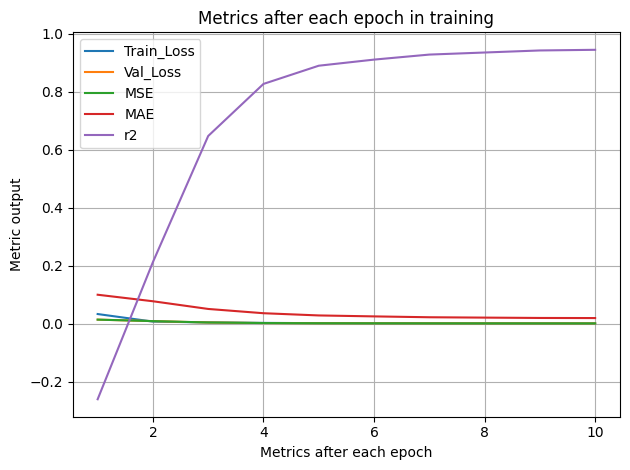

In [41]:
metrics = log_df.drop(columns="Epoch").columns

# Plot each feature
for col in metrics:
    plt.plot(log_df["Epoch"], log_df[col], label=col, linewidth=1.5)

plt.xlabel("Metrics after each epoch")
plt.ylabel("Metric output")
plt.title("Metrics after each epoch in training")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model Evaluation

In [42]:
def evaluate_model(model, data_loader, device, min_max_scaler, robust_scaler):
    model.eval()
    prediction = []
    actual = []

    with torch.no_grad():
        for inputs, true_values in data_loader:
            inputs, true_values = inputs.to(device), true_values.to(device)

            outputs = model(inputs)

            # Move to CPU and convert to numpy
            outputs_np = outputs.cpu().numpy()
            true_values_np = true_values.cpu().numpy()

            # Apply inverse transforms
            outputs_inv = robust_scaler.inverse_transform(
                min_max_scaler.inverse_transform(outputs_np)
            )
            true_inv = robust_scaler.inverse_transform(
                min_max_scaler.inverse_transform(true_values_np)
            )

            prediction.extend(outputs_inv)
            actual.extend(true_inv)

    # Compute metrics
    mae = mean_absolute_error(actual, prediction)
    mse = mean_squared_error(actual, prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, prediction)

    return mae, rmse, r2


In [43]:
os.makedirs(os.path.join(project_path, "models"), exist_ok=True) # Make directory in google drive
baseline_model_path = os.path.join(project_path,"models/best_baseline_model.pt")
new_model = model.to(device)
new_model.eval()

# Evaluate new model on test set
new_mae, new_rmse, new_r2 = evaluate_model(
    new_model,
    test_loader,
    device,
    min_max_scaler_dict["AT (degree C)"],
    robust_scaler_dict["AT (degree C)"]
)

if os.path.exists(baseline_model_path):
    # Load the existing (old) model
    old_model = LSTM(input_size, hidden_size, num_layers).to(device)  # create an instance of your model
    old_model.load_state_dict(torch.load(baseline_model_path))
    old_model.eval()

    # Evaluate the old model
    old_mae, old_rmse, old_r2 = evaluate_model(
        old_model,
        test_loader,
        device,
        min_max_scaler_dict["AT (degree C)"],
        robust_scaler_dict["AT (degree C)"]
    )

    print(f"Old_MAE  = {old_mae:.4f}  | New_MAE  = {new_mae:.4f}")
    print(f"Old_RMSE = {old_rmse:.4f} | New_RMSE = {new_rmse:.4f}")
    print(f"Old_R²   = {old_r2:.4f}   | New_R²   = {new_r2:.4f}")

    if new_mae < old_mae:
        print("🔁 New model is better — overwriting saved model.")
        torch.save(model.state_dict(), baseline_model_path)
        model = new_model
    else:
        print("✅ Existing model is still better.")
        model = old_model
else:
    print("📥 No existing model — saving new model.")
    os.makedirs("./models", exist_ok=True)
    torch.save(model.state_dict(), baseline_model_path)
    model = new_model

Old_MAE  = 0.7091  | New_MAE  = 0.7006
Old_RMSE = 0.8868 | New_RMSE = 0.8704
Old_R²   = 0.8884   | New_R²   = 0.8925
🔁 New model is better — overwriting saved model.


On average, the model predicts with an <span style="color:red;">error</span> of approximately **±0.6117°C**, as indicated by the MAE (Mean Absolute Error).

The RMSE (Root Mean Squared Error) is also low at **≈0.0.7782°C**, suggesting that the errors are consistently small and not heavily influenced by outliers.

Meanwhile, the R² score is **0.9141**, which is very close to 1 — this indicates that the model explains 91.41% of the variance in the target variable.

Overall, this means the model:
- <span style="color:green">generalizes well</span>
- shows no signs of overfitting
- and performs strongly on unseen/new data.

#### Prediction Plot

In [44]:
def plot_results(model, data_loader, device, min_max_scaler, robust_scaler):
    model.eval()
    prediction = []
    actual = []

    with torch.no_grad():
        for inputs, true_values in data_loader:
            inputs, true_values = inputs.to(device), true_values.to(device)

            outputs = model(inputs)

            # Move to CPU and convert to numpy
            outputs_np = outputs.cpu().numpy()
            true_values_np = true_values.cpu().numpy()

            # Apply inverse transforms
            outputs_inv = robust_scaler.inverse_transform(
                min_max_scaler.inverse_transform(outputs_np)
            )
            true_inv = robust_scaler.inverse_transform(
                min_max_scaler.inverse_transform(true_values_np)
            )

            prediction.extend(outputs_inv)
            actual.extend(true_inv)

    # Compute metrics
    test_result = pd.DataFrame({
        "Actual": actual,
        "Predicted": prediction
    })

    # Plot each feature
    for col in test_result.columns:
        plt.plot(test_result.index, test_result[col], label=col, linewidth=1.5, alpha=0.7)

    plt.xlabel("Metrics after each epoch")
    plt.ylabel("Metric output")
    plt.title("Metrics after each epoch in training")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


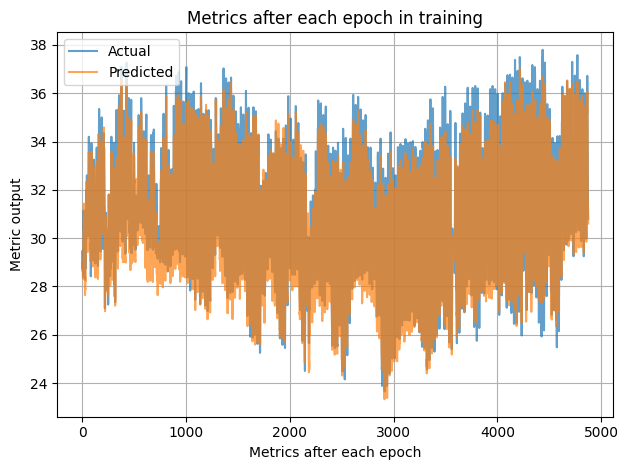

In [45]:
plot_results(model, test_loader, device, min_max_scaler_dict["AT (degree C)"], robust_scaler_dict["AT (degree C)"])

### Proposed Model

We will use optuna to fine tune the model

#### Model Builder

In [46]:
def define_model(trial, input_size, n_output):
    class GridLSTM(nn.Module):
        def __init__(self, trial, input_size: int, hidden_size: int, num_layers: int):
            super().__init__()

            def dense_layer_builder(layer_prefix):
                nonlocal input_size, dense_layers

                # Dense layer parameters
                out_size = trial.suggest_int(f"{layer_prefix}_output_size", 32, 512)
                dense_layers.append(nn.Linear(input_size, out_size))

                # Add drop out rate so that it reduces overfitting and improve generlization
                dropout_rate = trial.suggest_float(f"{layer_prefix}_dropout_rate", 0.0, 0.5)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate)) # Update input size for the next dense layer based on the output size of this one

                input_size = out_size

            dropout = trial.suggest_float("lstm_dropout", 0.0, 0.5)

            self.hidden_size = hidden_size
            self.num_layers = num_layers

            self.lstm = nn.LSTM(
                input_size = input_size,
                hidden_size = hidden_size, #number of LSTM Blocks
                num_layers = num_layers, #number of LSTM layers
                batch_first = True, # so that pytorch recognizes the input to be [batch_size, sequence_length, input_size] otherwise [sequence_length, batch_size, input_size]
                dropout = dropout
            )

            # Make the dense layers
            dense_layers = []
            input_size = hidden_size
            n_dense_layers = trial.suggest_int("n_dense_layer", 1, 4)

            for i in range(n_dense_layers):
                dense_layer_builder(f"dense_{i}") #input size would be updated each iteration

            #output Layer
            dense_layers.append(nn.Linear(input_size, 1)) #make a dense layer with a hidden_size number of neurons

            # Register dense layers as nn.Sequential
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, input_tensor): # Forward pass
            batch_size = input_tensor.size(0)

            # Initialize fresh clear memory every batch
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            # LSTM Forward pass
            out, _ = self.lstm(input_tensor, (h0, c0)) # out: [batch_size, seq_len, hidden_size]
            out = self.dense(out[:, -1, :]) # take the last time step and pass it to the dense layer
            return out

    hidden_size = trial.suggest_int("lstm_hidden_size", 10, 512)
    num_layers = trial.suggest_int("lstm_num_layers", 1, 3)
    return GridLSTM(trial, input_size, hidden_size, num_layers)

#### Setup Optuna Objective

In [47]:
# set the seed to 42
SEED = 42

def objective(trial, n_input, n_output, train_loader, val_loader, epochs, device, min_max_scaler, robust_scaler):
    # Reset the seed for each trial of the gridsearch
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Parameters for early stopping
    best_MSE = float("inf") # Initial MSE score
    patience = 3 # number of epochs to wait without improvement before stopping
    epochs_no_improve = 0 # Epochs counter without improvement
    best_model_state = None # To store the best model weights

    # Model Initialization
    model = define_model(trial, n_input, n_output).to(device)

    # Optimizer Set-Up
    optimizer_name = trial.suggest_categorical("Optimizer", ["Adam", "Momentum", "AdamW"])

    # Learning rate
    lr = trial.suggest_float("Learning_rate", 1e-5, 1e-1, log=True)  # log-scale search

    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "Momentum": optim.SGD(model.parameters(),
                              lr=lr,
                              momentum=trial.suggest_float("sgd_momentum", 1e-5, 1, log=True)),
        "AdamW": optim.AdamW(model.parameters(),
                             lr=lr,
                             weight_decay=trial.suggest_float("adamw_weight_decay", 1e-5, 1, log=True))
    }[optimizer_name]

    # Loss function
    loss_function = nn.MSELoss() # Mean squared error for regression

    for epoch in tqdm(range(epochs), desc="Training model..."):
        # Training loop
        model.train()
        for inputs, true_values in train_loader:
            inputs, true_values = inputs.to(device), true_values.to(device) # Set the device to train on

            optimizer.zero_grad() # Resets all the gradients since pytorch accumulates gradients from previous training
            outputs = model(inputs) # Runs a forward pass
            loss = loss_function(outputs, true_values) # Calculates the error
            loss.backward() # Runs a Backward pass
            optimizer.step() # Updates model trainable parameters

        # Early Stopping Check
        # Validation (after training loop finishes)
        # For the model predictions and actual values
        prediction = []
        actual = []

        with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
            for inputs, true_values in val_loader:
                inputs, true_values = inputs.to(device), true_values.to(device) # move lables to the device
                outputs = model(inputs) # Pass input data to the model to get raw logits
                predicted = outputs # gets the predicted values.

                predicted = outputs.cpu().numpy()
                true_vals = true_values.cpu().numpy()

                # Inverse scale
                y_pred_inv = robust_scaler.inverse_transform(
                    min_max_scaler.inverse_transform(predicted)
                )
                y_true_inv = robust_scaler.inverse_transform(
                    min_max_scaler.inverse_transform(true_vals)
                )

                prediction.extend(y_pred_inv)
                actual.extend(y_true_inv)

        # Calculate MSE
        MSE = mean_squared_error(actual, prediction) # Calculate MSE

        if MSE < best_MSE:
            best_MSE = MSE
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict()) # Save the model state
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                tqdm.write(f"Early stopping at epoch {epoch}")
                tqdm.write(f"Trial {trial.number}: MSE = {MSE:.4f}") #for easier logging
                break

        clear_output(wait=True)

    # Save best model to trial
    # Save best model to trial attributes
    # Correctly store the best model, not the last one
    if best_model_state:
        trial.set_user_attr("best_model_state", best_model_state)
    else:
        trial.set_user_attr("best_model_state", model.state_dict())

    return MSE

### This will be Continued in Google Colab

#### Initiate Gridsearch

In [48]:
# The input size
input_size = x_train.shape[2]

# Get number of outputs
output_size = 1
epochs = 10
n_trials = 100

samplers = optuna.samplers.TPESampler(n_startup_trials=20) # Bayesian optimization method used by Optuna to sample hyperparameters intelligently (20 random trials first before starting the Bayesian optimization.)
study = optuna.create_study(direction="minimize", sampler=samplers) # Minimize the MSE(Mean Squared Error)

# Tqdm for cleaner output
progress_bar = tqdm(total=n_trials, desc="Trial", ncols=80)

for _ in tqdm(range(n_trials), desc="Gridsearch ..."):
    time.sleep(3) #wait for 3 seconds befor clearing the output
    clear_output(wait=True) # comment this out of you want to see the whole training process
    study.optimize(lambda trial: objective(trial,input_size, output_size, train_loader,
                                           val_loader, epochs, device, min_max_scaler_dict["AT (degree C)"],
                                           robust_scaler_dict["AT (degree C)"]),
                   n_trials=1, timeout=5000)

# Summarize study results
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) # get the pruned trials
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]) # get the succeeded trials

print("\nStudy statistics:")
print(f"  Finished trials: {len(study.trials)}")
print(f"  Pruned trials:   {len(pruned_trials)}")
print(f"  Complete trials: {len(complete_trials)}")

trial = study.best_trial

# Define model with best params
best_trial = study.best_trial
print("Best trial:")
print(f"  MSE: {best_trial.value:.4f}")
best_proposed_model = define_model(best_trial, input_size, output_size).to(device)
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Load best weights
best_proposed_model.load_state_dict(best_trial.user_attrs["best_model_state"])






Trial:   0%|                                          | 0/100 [1:17:12<?, ?it/s]

Training model...:  60%|██████    | 6/10 [00:27<00:16,  4.11s/it]



Trial:   0%|                                          | 0/100 [1:17:12<?, ?it/s]

Training model...:  60%|██████    | 6/10 [00:27<00:18,  4.66s/it]
[I 2025-06-27 20:32:06,935] Trial 99 finished with value: 0.6285195005642153 and parameters: {'lstm_hidden_size': 298, 'lstm_num_layers': 1, 'lstm_dropout': 0.2806461852572158, 'n_dense_layer': 1, 'dense_0_output_size': 365, 'dense_0_dropout_rate': 0.022433274575218785, 'Optimizer': 'AdamW', 'Learning_rate': 0.00047320778428223346, 'sgd_momentum': 1.091586943339675e-05, 'adamw_weight_decay': 0.0011168439197077264}. Best is trial 90 with value: 0.39894620370321915.

Gridsearch ...: 100%|██████████| 100/100 [1:17:12<00:00, 46.33s/it]

Early stopping at epoch 6
Trial 99: MSE = 0.6285

Study statistics:
  Finished trials: 100
  Pruned trials:   0
  Complete trials: 100
Best trial:
  MSE: 0.3989
Best hyperparameters:
  lstm_hidden_size: 238
  lstm_num_layers: 1
  lstm_dropout: 0.3969672955191136
  n_dense_layer: 1
  dense_0_output_size: 399
  dense_0_dropout_rate: 9.031539413349027e-05
  Optimizer: AdamW
  Learning_rate: 0.00020427127879395579
  sgd_momentum: 0.12486750613691898
  adamw_weight_decay: 0.0006848541624989974



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3969672955191136 and num_layers=1
  warnings.warn(


<All keys matched successfully>

In [60]:
print("Best trial:")
trial = study.best_trial

print(f"  Value (objective score): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (objective score): 0.39894620370321915
  Params:
    lstm_hidden_size: 238
    lstm_num_layers: 1
    lstm_dropout: 0.3969672955191136
    n_dense_layer: 1
    dense_0_output_size: 399
    dense_0_dropout_rate: 9.031539413349027e-05
    Optimizer: AdamW
    Learning_rate: 0.00020427127879395579
    sgd_momentum: 0.12486750613691898
    adamw_weight_decay: 0.0006848541624989974


#### Model Evaluation

###### Build Old Model Function

In [51]:
def define_model_from_params(params: dict, input_size: int, n_output: int):
    class GridLSTM(nn.Module):
        def __init__(self):
            super().__init__()

            self.hidden_size = params["lstm_hidden_size"]
            self.num_layers = params["lstm_num_layers"]
            dropout = params.get("lstm_dropout", 0.0)

            self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                dropout=dropout
            )

            # Build dense layers
            dense_layers = []
            dense_input_size = self.lstm.hidden_size
            n_dense_layers = params.get("n_dense_layer", 1)

            for i in range(n_dense_layers):
                out_size = params[f"dense_{i}_output_size"]
                dense_layers.append(nn.Linear(dense_input_size, out_size))

                dropout_rate = params.get(f"dense_{i}_dropout_rate", 0.0)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate))

                dense_input_size = out_size

            # Output layer
            dense_layers.append(nn.Linear(dense_input_size, 1))
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, x):
            batch_size = x.size(0)
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

            out, _ = self.lstm(x, (h0, c0))
            out = self.dense(out[:, -1, :])
            return out

    return GridLSTM()

In [54]:
purposed_model_pytorch_path = os.path.join(project_path,"models/best_proposed_model.pt")
purposed_model_json_path = os.path.join(project_path,"models/best_proposed_model.json")
new_proposed_model = best_proposed_model.to(device)
new_proposed_model.eval()

# Evaluate new model on test set
new_mae, new_rmse, new_r2 = evaluate_model(
    new_proposed_model,
    test_loader,
    device,
    min_max_scaler_dict["AT (degree C)"],
    robust_scaler_dict["AT (degree C)"]
)

if os.path.exists(purposed_model_pytorch_path) and os.path.exists(purposed_model_json_path):
    # Load the existing (old) model
    with open(purposed_model_json_path, "r") as f:
        best_params = json.load(f)

    old_proposed_model = define_model_from_params(best_params, input_size, output_size).to(device)
    old_proposed_model.load_state_dict(torch.load(purposed_model_pytorch_path))
    old_proposed_model.eval()

    # Evaluate the old model
    old_mae, old_rmse, old_r2 = evaluate_model(
        old_proposed_model,
        test_loader,
        device,
        min_max_scaler_dict["AT (degree C)"],
        robust_scaler_dict["AT (degree C)"]
    )

    print(f"Old_MAE  = {old_mae:.4f}  | New_MAE  = {new_mae:.4f}")
    print(f"Old_RMSE = {old_rmse:.4f} | New_RMSE = {new_rmse:.4f}")
    print(f"Old_R²   = {old_r2:.4f}   | New_R²   = {new_r2:.4f}")

    if new_mae < old_mae:
        print("🔁 New model is better — overwriting saved model.")
        torch.save(new_proposed_model.state_dict(), purposed_model_pytorch_path)
        with open(purposed_model_json_path, "w") as f:
            json.dump(best_trial.params, f, indent=4)
        proposed_model = new_proposed_model
    else:
        print("✅ Existing model is still better.")
        proposed_model = old_proposed_model
else:
    print("📥 No existing model — saving new model.")
    os.makedirs("./models", exist_ok=True)
    torch.save(new_proposed_model.state_dict(), purposed_model_pytorch_path)
    with open(purposed_model_json_path, "w") as f:
        json.dump(best_trial.params, f, indent=4)
    proposed_model = new_proposed_model


📥 No existing model — saving new model.


In [59]:
mae, rmse, r2 = evaluate_model(
        proposed_model,
        test_loader,
        device,
        min_max_scaler_dict["AT (degree C)"],
        robust_scaler_dict["AT (degree C)"]
    )

print(f"MAE  = {mae:.4f}")
print(f"MSE = {sqrt(rmse):.4f}")
print(f"R²   = {r2:.4f}")

MAE  = 0.4256
MSE = 0.7678
R²   = 0.9507


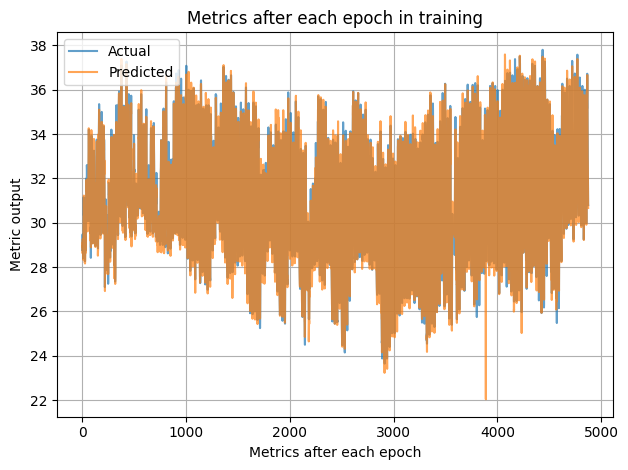

In [56]:
plot_results(proposed_model, test_loader, device, min_max_scaler_dict["AT (degree C)"], robust_scaler_dict["AT (degree C)"])

## Conclusion in the Non-Colab Notebook